# Data Sources

Get data 

## import

In [399]:
import os
import sys
import time
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()



## definitions

In [352]:
#yf_eth = yf.Ticker("ETH-USD")
#yf_btc = yf.Ticker("BTC-USD")

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))
ETH_TICK = "ETH/USDT"
BTC_TICK = "BTC/USDT"
BNB_TICK = "BNB/USDT"
FIRST_DATE = "2021-01-01 00:00:00"
LAST_DATE =  "2023-02-13 00:00:00"
TIMEFRAME = "1h"
PATH_DATA = "data"
path_save_df_eth = "data/df_eth.csv"
path_save_df_eth_2 = "data/df_eth_2.csv"
path_save_df_btc = "data/df_btc.csv"
path_save_df_btc_2 = "data/df_btc_2.csv"
path_save_df_bnb = "data/df_bnb.csv"
path_save_df_bnb_2 = "data/df_bnb_2.csv"
path_save_df_eco = "data/df_eco.csv"

# CCXT crypto exchanges declaration
exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

kucoin = ccxt.kucoin({
    'rateLimit': 1,
    'enableRateLimit': True,
})


## Download data

In [3]:
# params
#ticker = ETH_TICK
#from_datetime = FIRST_DATE
#to_datetime = LAST_DATE



# def
def req_ohlcv(
        exchange,
        ticker,
        timeframe,
        from_datetime,  
        to_datetime=None
    ):
    
    # common constants
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    hold = 30

    from_timestamp = exchange.parse8601(from_datetime)

    if to_datetime is None:
        to_timestamp = exchange.milliseconds()
    else:
        to_timestamp = exchange.parse8601(to_datetime)
        

    data = []

    while from_timestamp < to_timestamp:

        try:

            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(from_timestamp))
            ohlcvs = exchange.fetch_ohlcv(ticker, timeframe, from_timestamp)
            print(exchange.milliseconds(), 'Fetched', len(ohlcvs), 'candles')
            first = ohlcvs[0][0]
            last = ohlcvs[-1][0]
            print('First candle epoch', first, exchange.iso8601(first))
            print('Last candle epoch', last, exchange.iso8601(last))
            from_timestamp += len(ohlcvs) * hour
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:

            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    
    df = pd.DataFrame(data)
    df.columns = (["Time", "Open", "High", "Low", "Close", "Volume"])

    df['date'] = pd.to_datetime(df['Time'], unit='ms')

    return df

def check_data():
    return (
        os.path.isfile(path_save_df_eth) &
        os.path.isfile(path_save_df_btc) &
        os.path.isfile(path_save_df_bnb)
    )

def check_data_2():
    return (
        os.path.isfile(path_save_df_eth_2) &
        os.path.isfile(path_save_df_btc_2) &
        os.path.isfile(path_save_df_bnb_2)
    )


def test_time_continuity(df):
    try:
        assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = df["Time"].diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except:
        
        return False

def add_nb_time(df_in):
    """
    modify index to be the n-th time-step from first time.
    so a gap in time is reflected into index.
    add nb_time columns (maybe useless).
    """
    df = df_in.copy()
    delta_min = df["Time"].diff().value_counts().index[0]
    df["nb_time"] = ((df["Time"] - df["Time"].values[0]) / delta_min).astype(np.int64)
    df.index = df["nb_time"].values

    list_index = (
        list(set(list(range(df["nb_time"].values[-1]))) 
             - set(list(df["nb_time"].values)))
    )


    return df, list_index

def fill_time_gap(df_in, df_2):
    """
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin)
    So we use all prices of kucoin for missage dates
    Also, we add estimate unkonwn binance volumes in proportion of previous 
    "hour" known volumes from the two exchanges.

    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in abosolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            raise Exception("Error good input data 2")
    else:
        return df


In [4]:
data_ok = check_data()
print(data_ok)

True


In [5]:
if not data_ok:
    

    
    df_eth = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        FIRST_DATE,  
        LAST_DATE,
    )

    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = req_ohlcv(
            exchange,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    df_btc.drop_duplicates(subset=['Time'], inplace=True)
 
    df_bnb = req_ohlcv(
            exchange,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # save on disk
    df_eth.to_csv(path_save_df_eth, index=False)
    df_btc.to_csv(path_save_df_btc, index=False)
    df_bnb.to_csv(path_save_df_bnb, index=False)

else:
    # simply reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)
    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)
    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

print("df_eth: ", df_eth.shape)
print("df_btc: ", df_btc.shape)
print("df_bnb: ", df_bnb.shape)

Reload data binance exchange from disk...
df_eth:  (18556, 7)
df_btc:  (18556, 7)
df_bnb:  (18556, 7)


In [6]:

data_ok_2 = check_data_2()

if not data_ok_2:

    

    df_eth_2 = req_ohlcv(
            kucoin,
            ETH_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_btc_2 = req_ohlcv(
            kucoin,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_bnb_2 = req_ohlcv(
            kucoin,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    # save on disk
    df_eth_2.to_csv(path_save_df_eth_2, index=False)
    df_btc_2.to_csv(path_save_df_btc_2, index=False)
    df_bnb_2.to_csv(path_save_df_bnb_2, index=False)

else:
    # simply reload from disk
    print("Reload data kucoin exchange from disk...")
    df_eth_2 = pd.read_csv(path_save_df_eth_2)
    df_btc_2 = pd.read_csv(path_save_df_btc_2)
    df_bnb_2 = pd.read_csv(path_save_df_bnb_2)   

print("df_eth kucoin: ", df_eth_2.shape)
print("df_btc kucoin: ", df_btc_2.shape)
print("df_bnb kucoin: ", df_bnb_2.shape)



Reload data kucoin exchange from disk...
df_eth kucoin:  (18571, 7)
df_btc kucoin:  (18571, 7)
df_bnb kucoin:  (18571, 7)


In [7]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00
...,...,...,...,...,...,...,...
18564,1676289600000,1486.07,1491.89,1484.06,1487.32,19492.91240,2023-02-13 12:00:00
18565,1676293200000,1487.31,1488.80,1477.66,1477.98,28307.80350,2023-02-13 13:00:00
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.36010,2023-02-13 14:00:00
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.65050,2023-02-13 15:00:00


In [8]:
df_test = fill_time_gap(df_eth, df_eth_2)

Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volume index 2742
Correcting volume index 2743
Correcting volume index 2618
Correcting volume index 2619
Correcting volume index 988


In [9]:
diff_time = df_eth["Time"].diff()
df_eth.iloc[np.argmax(diff_time)-5:np.argmax(diff_time)+5]

,Time,Open,High,Low,Close,Volume,date
5373,1628802000000,3066.29,3071.00,3031.03,3043.30,12167.10571,2021-08-12 21:00:00
5374,1628805600000,3043.35,3049.73,2985.91,2998.99,25773.04397,2021-08-12 22:00:00
5375,1628809200000,2999.00,3049.55,2998.99,3045.96,23688.80488,2021-08-12 23:00:00
5376,1628812800000,3046.11,3073.89,3033.80,3062.18,26306.11420,2021-08-13 00:00:00
5377,1628816400000,3062.18,3097.00,3055.30,3088.22,23702.03514,2021-08-13 01:00:00
5378,1628834400000,3088.23,3186.00,3088.22,3184.52,28370.16757,2021-08-13 06:00:00
5379,1628838000000,3184.53,3231.83,3184.53,3222.99,58228.69375,2021-08-13 07:00:00
5380,1628841600000,3222.99,3251.20,3216.43,3234.95,47701.08929,2021-08-13 08:00:00
5381,1628845200000,3234.96,3249.00,3221.30,3225.38,26186.31119,2021-08-13 09:00:00
5382,1628848800000,3225.01,3260.25,3225.01,3235.57,33575.18407,2021-08-13 10:00:00


In [10]:
df_test.loc[np.argmax(diff_time)+2:np.argmax(diff_time)+12]

,Time,Open,High,Low,Close,Volume,date
5373,1628802000000,3066.29,3071.00,3031.03,3043.30,12167.105710,2021-08-12 21:00:00
5374,1628805600000,3043.35,3049.73,2985.91,2998.99,25773.043970,2021-08-12 22:00:00
5375,1628809200000,2999.00,3049.55,2998.99,3045.96,23688.804880,2021-08-12 23:00:00
5376,1628812800000,3046.11,3073.89,3033.80,3062.18,26306.114200,2021-08-13 00:00:00
5377,1628816400000,3062.18,3097.00,3055.30,3088.22,23702.035140,2021-08-13 01:00:00
5378,1628820000000,3088.58,3142.73,3086.21,3129.13,34888.391864,2021-08-13 02:00:00
5379,1628823600000,3129.20,3137.26,3110.73,3115.30,23092.746220,2021-08-13 03:00:00
5380,1628827200000,3115.45,3128.83,3091.70,3119.56,23571.037829,2021-08-13 04:00:00
5381,1628830800000,3119.67,3145.00,3110.00,3129.40,19218.890115,2021-08-13 05:00:00
5382,1628834400000,3088.23,3186.00,3088.22,3184.52,28370.167570,2021-08-13 06:00:00


In [11]:
df_eth_2.loc[np.argmax(diff_time)+2:np.argmax(diff_time)+12]

,Time,Open,High,Low,Close,Volume,date
5373,1628802000000,3066.09,3069.68,3031.21,3043.82,3772.980336,2021-08-12 21:00:00
5374,1628805600000,3043.82,3050.18,2985.06,2998.78,4431.694191,2021-08-12 22:00:00
5375,1628809200000,2999.48,3050.42,2998.71,3046.45,4501.299494,2021-08-12 23:00:00
5376,1628812800000,3046.46,3073.19,3034.18,3062.31,4863.296806,2021-08-13 00:00:00
5377,1628816400000,3063.12,3096.75,3056.01,3088.59,3366.518309,2021-08-13 01:00:00
5378,1628820000000,3088.58,3142.73,3086.21,3129.13,4955.372368,2021-08-13 02:00:00
5379,1628823600000,3129.20,3137.26,3110.73,3115.30,3279.977964,2021-08-13 03:00:00
5380,1628827200000,3115.45,3128.83,3091.70,3119.56,3347.912108,2021-08-13 04:00:00
5381,1628830800000,3119.67,3145.00,3110.00,3129.40,2729.754853,2021-08-13 05:00:00
5382,1628834400000,3129.40,3185.35,3116.84,3184.00,5997.736925,2021-08-13 06:00:00


In [12]:
df_eth = fill_time_gap(df_eth, df_eth_2)
df_btc = fill_time_gap(df_btc, df_btc_2)
df_bnb = fill_time_gap(df_bnb, df_bnb_2)

Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volume index 2742
Correcting volume index 2743
Correcting volume index 2618
Correcting volume index 2619
Correcting volume index 988
Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volume index 2742
Correcting volume index 2743
Correcting volume index 2618
Correcting volume index 2619
Correcting volume index 988
Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volum

In [13]:
df_eth["Time"].diff().value_counts()

3600000.0    18570
Name: Time, dtype: int64

## Tests

## Add indicators

Ichimoku 1h 1D 1W

In [14]:
def add_ichimoku(df):
    """
    Create & add ichimoku data at different ranges : 1h 1D 1W
    Take timestep 1h data as input only

    Ex: df_out = add_ichimoku(df_in)
    
    """

    df_out = df.copy()

    indic_ichi = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True
    )
    df_out["ichi_cloud_a"] = indic_ichi.ichimoku_a()
    df_out["ichi_cloud_b"] = indic_ichi.ichimoku_b()
    df_out["ichi_kijun"] = indic_ichi.ichimoku_base_line()
    df_out["ichi_tenkan"] = indic_ichi.ichimoku_conversion_line()

    indic_ichi_day = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24,
        window2=26*24,
        window3=52*24,
    )
    df_out["ichi_cloud_a_day"] = indic_ichi_day.ichimoku_a()
    df_out["ichi_cloud_b_day"] = indic_ichi_day.ichimoku_b()
    df_out["ichi_kijun_day"] = indic_ichi_day.ichimoku_base_line()
    df_out["ichi_tenkan_day"] = indic_ichi_day.ichimoku_conversion_line()

    indic_ichi_week = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24*7,
        window2=26*24*7,
        window3=52*24*7,
    )
    df_out["ichi_cloud_a_week"] = indic_ichi_week.ichimoku_a()
    df_out["ichi_cloud_b_week"] = indic_ichi_week.ichimoku_b()
    df_out["ichi_kijun_week"] = indic_ichi_week.ichimoku_base_line()
    df_out["ichi_tenkan_week"] = indic_ichi_week.ichimoku_conversion_line()

    return df_out

df_eth = add_ichimoku(df_eth)


In [15]:
df_eth[["ichi_kijun", "ichi_kijun_day", "ichi_kijun_week"]]

,ichi_kijun,ichi_kijun_day,ichi_kijun_week
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
18566,1507.010,1590.340,1516.48
18567,1507.010,1590.340,1516.48
18568,1504.975,1588.305,1516.48
18569,1504.975,1588.305,1516.48


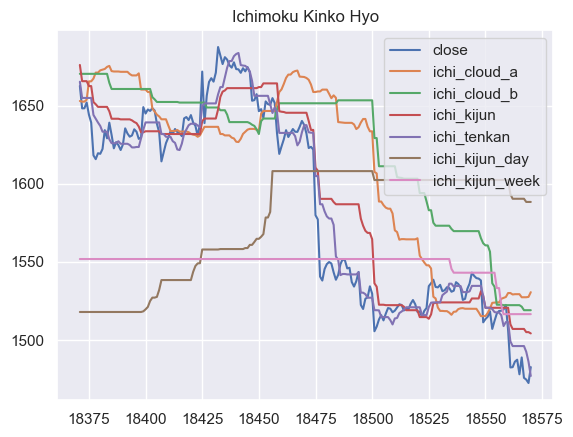

In [16]:
plt.plot(df_eth[-200:].Close, label="close")
plt.plot(df_eth[-200:]["ichi_cloud_a"], label='ichi_cloud_a')
plt.plot(df_eth[-200:]["ichi_cloud_b"], label='ichi_cloud_b')
plt.plot(df_eth[-200:]["ichi_kijun"], label='ichi_kijun')
plt.plot(df_eth[-200:]["ichi_tenkan"], label='ichi_tenkan')
plt.plot(df_eth[-200:]["ichi_kijun_day"], label='ichi_kijun_day')
plt.plot(df_eth[-200:]["ichi_kijun_week"], label='ichi_kijun_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

RSI 14  1h 1D 1W

In [46]:

# RSIIndicator(close: pandas.core.series.Series, window: int = 14, fillna: bool = False)
def add_rsi(df, n=14):
    df_out = df.copy()
    df_out["rsi_h"] = RSIIndicator(df["High"], window=n).rsi()
    df_out["rsi_d"] = RSIIndicator(df["High"], window=n*24).rsi()
    df_out["rsi_w"] = RSIIndicator(df["High"], window=n*24*7).rsi()
    return df_out


df_eth = add_rsi(df_eth)
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,ichi_cloud_b_day,ichi_kijun_day,ichi_tenkan_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week,rsi_h,rsi_d,rsi_w
0,1609459200000,736.42,739.00,729.33,734.07,27932.698840,2021-01-01 00:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.187790,2021-01-01 01:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.501000,2021-01-01 02:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.808590,2021-01-01 03:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.154240,2021-01-01 04:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.360100,2023-02-13 14:00:00,1527.295000,1521.265000,1507.010,...,1380.255000,1590.340,1581.955,1843.365000,2874.78000,1516.48,1432.595,30.187509,47.803232,49.865099
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.650500,2023-02-13 15:00:00,1527.295000,1519.005000,1507.010,...,1380.255000,1590.340,1581.955,1843.365000,2874.78000,1516.48,1432.595,30.992124,47.826521,49.867644
18568,1676304000000,1475.71,1487.88,1461.93,1474.58,36687.889000,2023-02-13 16:00:00,1527.295000,1519.005000,1504.975,...,1380.255000,1588.305,1579.920,1843.365000,2874.78000,1516.48,1432.595,30.071140,47.773766,49.861396
18569,1676307600000,1475.53,1480.29,1462.37,1472.40,2423.804905,2023-02-13 17:00:00,1527.530000,1519.005000,1504.975,...,1380.255000,1588.305,1579.920,1843.365000,2874.78000,1516.48,1432.595,26.662544,47.563557,49.836441


Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:  

  – n is the user-defined period length  
  – ATR(1) is the Average True Range (Period of 1)  
  – SUM(ATR(1), n) is the sum of the Average True Range over past n periods  
  – MaxHi(n) is the the highest high over the past n periods  
  – MinLo(n) is the lowest low over the past n periods  

In [47]:
# add CHOP indicator on 1hour 1day 1week 
def add_chop(df, n):
    df_out = df.copy()

    def calculate_chop(df, n, k):
        #(high: pandas.core.series.Series, 
        # low: pandas.core.series.Series, 
        # close: pandas.core.series.Series, 
        # window: int = 14, 
        # fillna: bool = False)
        atr = AverageTrueRange(
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            window=1*k,
            ).average_true_range()
        sum_atr = atr.rolling(n*k).sum()
        max_high = df_out["High"].rolling(n*k).max()
        min_low = df_out["Low"].rolling(n*k).min()
        chop = 100 * np.log10(sum_atr / (max_high - min_low )) / np.log10(n*k)
        return chop, atr, max_high, min_low
    
    
    def  add_chop_col(df_out, n, k):
        chop, atr, max_high, min_low = calculate_chop(df_out, n, k)
        if k == 1:
            df_out["max_high_h"] = max_high
            df_out["min_low_h"] = min_low
            df_out["atr_h"] = atr
            df_out["chop_h"] = chop
        elif (k==24):
            df_out["max_high_d"] = max_high
            df_out["min_low_d"] = min_low
            df_out["atr_d"] = atr
            df_out["chop_d"] = chop   
        elif (k==24*7):
            df_out["max_high_w"] = max_high
            df_out["min_low_w"] = min_low
            df_out["atr_w"] = atr
            df_out["chop_w"] = chop  
        else:
            df_out[f"max_high_{k}"] = max_high
            df_out[f"min_low_{k}"] = min_low
            df_out[f"atr_{k}"] = atr
            df_out[f"chop_{k}"] = chop
        return df_out                       
    # 1h
    df_out = add_chop_col(df_out, n, 1)
    # 1day
    df_out = add_chop_col(df_out, n, 24)    
    # 1week
    df_out = add_chop_col(df_out, n, 24*7)

    return df_out

df_eth = add_chop(df_eth, 14)
df_eth[["date", "High", "Low", "Close", 
         "atr_h", "max_high_h","min_low_h", "chop_h",
         "atr_d", "max_high_d","min_low_d", "chop_d",
         "atr_w", "max_high_w","min_low_w", "chop_w"]].tail(30)


,date,High,Low,Close,atr_h,max_high_h,min_low_h,chop_h,atr_d,max_high_d,min_low_d,chop_d,atr_w,max_high_w,min_low_w,chop_w
18541,2023-02-12 13:00:00,1528.55,1521.43,1526.26,7.12,1540.06,1521.12,53.502634,8.341900,1714.68,1490.00,50.788159,11.997692,1714.68,1073.53,48.570803
18542,2023-02-12 14:00:00,1537.67,1524.67,1532.63,13.00,1540.06,1521.12,56.716327,8.535987,1714.68,1490.00,50.772184,12.003658,1714.68,1073.53,48.569511
18543,2023-02-12 15:00:00,1541.00,1530.00,1536.09,11.00,1541.00,1521.12,58.045611,8.638655,1714.68,1490.00,50.757576,11.997684,1714.68,1073.53,48.568225
18544,2023-02-12 16:00:00,1548.02,1534.23,1543.06,13.79,1548.02,1521.12,49.655629,8.853294,1714.68,1490.00,50.743749,12.008352,1714.68,1073.53,48.566939
18545,2023-02-12 17:00:00,1546.37,1539.77,1540.98,6.60,1548.02,1521.12,50.538064,8.759407,1714.68,1490.00,50.729818,11.976160,1714.68,1073.53,48.565653
18546,2023-02-12 18:00:00,1542.49,1538.04,1539.55,4.45,1548.02,1521.12,51.072469,8.579848,1714.68,1490.00,50.713987,11.931361,1714.68,1073.53,48.564351
18547,2023-02-12 19:00:00,1542.03,1535.89,1539.23,6.14,1548.02,1521.12,52.279045,8.478188,1714.68,1490.00,50.694641,11.896889,1714.68,1073.53,48.563050
18548,2023-02-12 20:00:00,1541.96,1536.67,1538.06,5.29,1548.02,1521.12,53.061443,8.345347,1714.68,1490.00,50.672316,11.857562,1714.68,1073.53,48.561752
18549,2023-02-12 21:00:00,1538.44,1508.33,1511.23,30.11,1548.02,1508.33,46.688780,9.252207,1714.68,1490.00,50.653568,11.966207,1714.68,1073.53,48.560518
18550,2023-02-12 22:00:00,1515.10,1493.08,1513.36,22.02,1548.02,1493.08,38.927862,9.784199,1714.68,1490.00,50.638504,12.026051,1714.68,1073.53,48.559304


VWAP (Volume-Weighted Average Price ) at 
- several period
  - 1 day
  - 1 week
  - 1 month
  - 3 months
  - 6 months
  - 12 months  
   
  
https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday  

- VWAP = Cumulative(Volume x Typical Price)/Cumulative(Volume) on a time period
  - Typical Price = (High+Low+Close)/3
  - Trying to have an indicator to estimate Volume profile?

- Close to Realized Price (https://www.decentrader.com/charts/mvrv/) : 
  - MVRV = Market Value / Realized Value
  - Market Value = Price x number of coins in circulation
  - Realized Value = Cost basis of all available bitcoins in the market.
  - MVRV can be approximate with = VWAP / Typical Price
- MVRV Z-Score
  - (Market Value - Realized Value) / Std(Market Value)
    - approxamte with  : on 1 period: (Typical Price - VWAP) / Std(Typical Price)

In [48]:
# TODO VWAP 1D 1W 1M 3M 6M 1Y for ETH and BTC
# VolumeWeightedAveragePrice(high: pandas.core.series.Series,
# low: pandas.core.series.Series, 
# close: pandas.core.series.Series, 
# volume: pandas.core.series.Series, 
# window: int = 14, 
# fillna: bool = False)
# volume_weighted_average_price
def add_vwap(df, n=1):
    df_out = df.copy()
    # 1hour
    df_out["vwap_h"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=14,
        fillna=True,
        ).volume_weighted_average_price()
    # 1day
    df_out["vwap_d"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24).volume_weighted_average_price()    
    # 1week
    df_out["vwap_w"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7).volume_weighted_average_price() 
    # 1month
    df_out["vwap_m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30).volume_weighted_average_price() 
    # 3months
    df_out["vwap_3m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*3).volume_weighted_average_price() 
    # 6months
    df_out["vwap_6m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*6).volume_weighted_average_price() 
    # 1year
    df_out["vwap_y"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=n*24*365,
        fillna=True,
        ).volume_weighted_average_price()
    # all time
    df_out["vwap_all"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=df_out.shape[0],
        fillna=True,
        ).volume_weighted_average_price()
    return df_out


df_eth = add_vwap(df_eth)
df_eth


,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,atr_w,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all
0,1609459200000,736.42,739.00,729.33,734.07,27932.698840,2021-01-01 00:00:00,2327.873364,2320.213654,NaN,...,0.000000,NaN,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333
1,1609462800000,734.08,749.00,733.37,748.28,52336.187790,2021-01-01 01:00:00,2327.873364,2320.213654,NaN,...,0.000000,NaN,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102
2,1609466400000,748.27,749.00,742.27,744.06,33019.501000,2021-01-01 02:00:00,2327.873364,2320.213654,NaN,...,0.000000,NaN,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885
3,1609470000000,744.06,747.23,743.10,744.82,17604.808590,2021-01-01 03:00:00,2327.873364,2320.213654,NaN,...,0.000000,NaN,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753
4,1609473600000,744.87,747.09,739.30,742.29,18794.154240,2021-01-01 04:00:00,2327.873364,2320.213654,NaN,...,0.000000,NaN,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.360100,2023-02-13 14:00:00,1527.295000,1521.265000,1507.010,...,12.110655,48.538908,1494.805244,1503.841836,1579.388900,1481.702894,2201.502163,2113.857563,1692.001058,2113.857563
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.650500,2023-02-13 15:00:00,1527.295000,1519.005000,1507.010,...,12.124163,48.537645,1493.052237,1502.192398,1578.009585,1481.685271,2201.382086,2113.832603,1691.923696,2113.832603
18568,1676304000000,1475.71,1487.88,1461.93,1474.58,36687.889000,2023-02-13 16:00:00,1527.295000,1519.005000,1504.975,...,12.206459,48.536408,1490.656671,1498.949029,1576.025397,1481.663327,2201.236595,2113.793481,1691.787273,2113.793481
18569,1676307600000,1475.53,1480.29,1462.37,1472.40,2423.804905,2023-02-13 17:00:00,1527.530000,1519.005000,1504.975,...,12.240469,48.535204,1490.037740,1497.863968,1575.685395,1481.665431,2201.175039,2113.790884,1691.720366,2113.790884


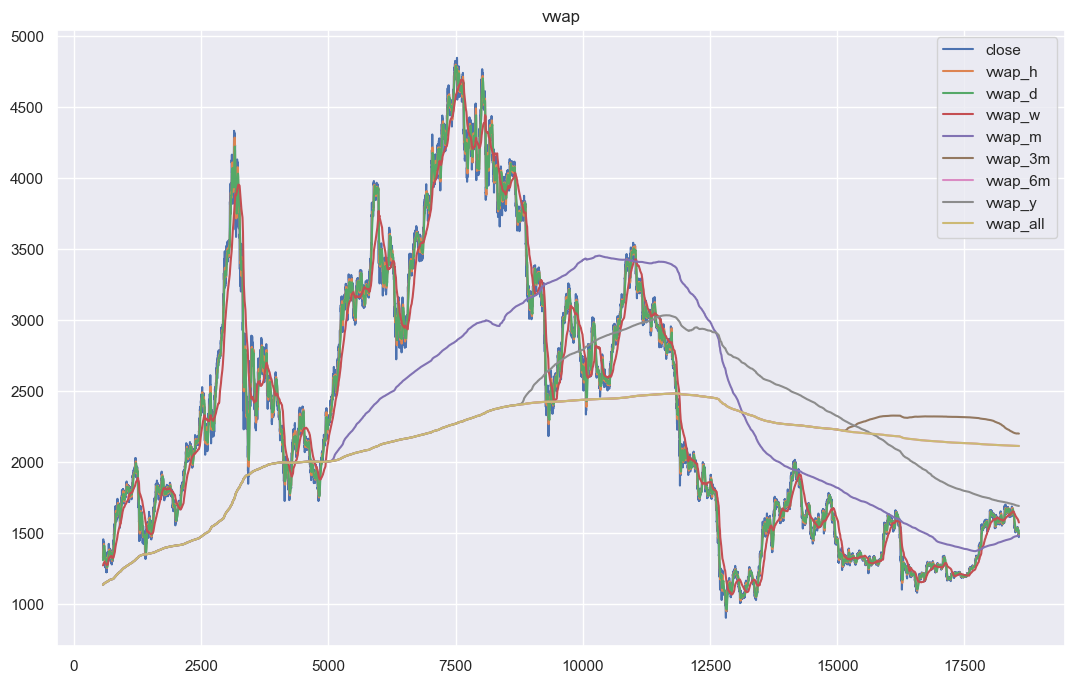

In [49]:
nb_point = 18000
fig = plt.figure()
fig.set_size_inches([13,8])
plt.plot(df_eth[-nb_point:].Close, label="close")
plt.plot(df_eth[-nb_point:]["vwap_h"], label='vwap_h')
plt.plot(df_eth[-nb_point:]["vwap_d"], label='vwap_d')
plt.plot(df_eth[-nb_point:]["vwap_w"], label='vwap_w')
plt.plot(df_eth[-nb_point:]["vwap_m"], label='vwap_m')
plt.plot(df_eth[-nb_point:]["vwap_3m"], label='vwap_3m')
plt.plot(df_eth[-nb_point:]["vwap_6m"], label='vwap_6m')
plt.plot(df_eth[-nb_point:]["vwap_y"], label='vwap_y')
plt.plot(df_eth[-nb_point:]["vwap_all"], label='vwap_all')
plt.title('vwap')
plt.legend()
plt.show()

In [50]:
# TODO MVRV Z-score : (Market Value - Realized Value) / Std(Market Value)
# approximated by : (Close - VWAP(all time) ) / Std(Close from first date)
nb_max_period = df_eth.shape[0]
df_eth["vwap_z_score"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"].expanding(1).std()
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score
0,1609459200000,736.42,739.00,729.33,734.07,27932.698840,2021-01-01 00:00:00,2327.873364,2320.213654,NaN,...,NaN,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.187790,2021-01-01 01:00:00,2327.873364,2320.213654,NaN,...,NaN,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,0.796866
2,1609466400000,748.27,749.00,742.27,744.06,33019.501000,2021-01-01 02:00:00,2327.873364,2320.213654,NaN,...,NaN,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,0.325738
3,1609470000000,744.06,747.23,743.10,744.82,17604.808590,2021-01-01 03:00:00,2327.873364,2320.213654,NaN,...,NaN,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,0.439488
4,1609473600000,744.87,747.09,739.30,742.29,18794.154240,2021-01-01 04:00:00,2327.873364,2320.213654,NaN,...,NaN,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,0.011168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.360100,2023-02-13 14:00:00,1527.295000,1521.265000,1507.010,...,48.538908,1494.805244,1503.841836,1579.388900,1481.702894,2201.502163,2113.857563,1692.001058,2113.857563,-0.635500
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.650500,2023-02-13 15:00:00,1527.295000,1519.005000,1507.010,...,48.537645,1493.052237,1502.192398,1578.009585,1481.685271,2201.382086,2113.832603,1691.923696,2113.832603,-0.648756
18568,1676304000000,1475.71,1487.88,1461.93,1474.58,36687.889000,2023-02-13 16:00:00,1527.295000,1519.005000,1504.975,...,48.536408,1490.656671,1498.949029,1576.025397,1481.663327,2201.236595,2113.793481,1691.787273,2113.793481,-0.649870
18569,1676307600000,1475.53,1480.29,1462.37,1472.40,2423.804905,2023-02-13 17:00:00,1527.530000,1519.005000,1504.975,...,48.535204,1490.037740,1497.863968,1575.685395,1481.665431,2201.175039,2113.790884,1691.720366,2113.790884,-0.652088


NUPL : Net Unrealized Profit/Loss
- NUPL = (Market Value - Realized Value) / Market Value
- https://academy.glassnode.com/indicators/profit-loss-unrealized/net-unrealized-profit-loss
- https://www.lookintobitcoin.com/charts/relative-unrealized-profit--loss/

- Approximated with :  = (Typical Price - VWAP) / Typical Price on all times



In [53]:
# TODO : NUPL ?
df_eth["nupl"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"]
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl
0,1609459200000,736.42,739.00,729.33,734.07,27932.698840,2021-01-01 00:00:00,2327.873364,2320.213654,NaN,...,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,NaN,-0.000086
1,1609462800000,734.08,749.00,733.37,748.28,52336.187790,2021-01-01 01:00:00,2327.873364,2320.213654,NaN,...,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,0.796866,0.010700
2,1609466400000,748.27,749.00,742.27,744.06,33019.501000,2021-01-01 02:00:00,2327.873364,2320.213654,NaN,...,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,0.325738,0.003195
3,1609470000000,744.06,747.23,743.10,744.82,17604.808590,2021-01-01 03:00:00,2327.873364,2320.213654,NaN,...,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,0.439488,0.003604
4,1609473600000,744.87,747.09,739.30,742.29,18794.154240,2021-01-01 04:00:00,2327.873364,2320.213654,NaN,...,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,0.011168,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.360100,2023-02-13 14:00:00,1527.295000,1521.265000,1507.010,...,1494.805244,1503.841836,1579.388900,1481.702894,2201.502163,2113.857563,1692.001058,2113.857563,-0.635500,-0.419868
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.650500,2023-02-13 15:00:00,1527.295000,1519.005000,1507.010,...,1493.052237,1502.192398,1578.009585,1481.685271,2201.382086,2113.832603,1691.923696,2113.832603,-0.648756,-0.432417
18568,1676304000000,1475.71,1487.88,1461.93,1474.58,36687.889000,2023-02-13 16:00:00,1527.295000,1519.005000,1504.975,...,1490.656671,1498.949029,1576.025397,1481.663327,2201.236595,2113.793481,1691.787273,2113.793481,-0.649870,-0.433489
18569,1676307600000,1475.53,1480.29,1462.37,1472.40,2423.804905,2023-02-13 17:00:00,1527.530000,1519.005000,1504.975,...,1490.037740,1497.863968,1575.685395,1481.665431,2201.175039,2113.790884,1691.720366,2113.790884,-0.652088,-0.435609


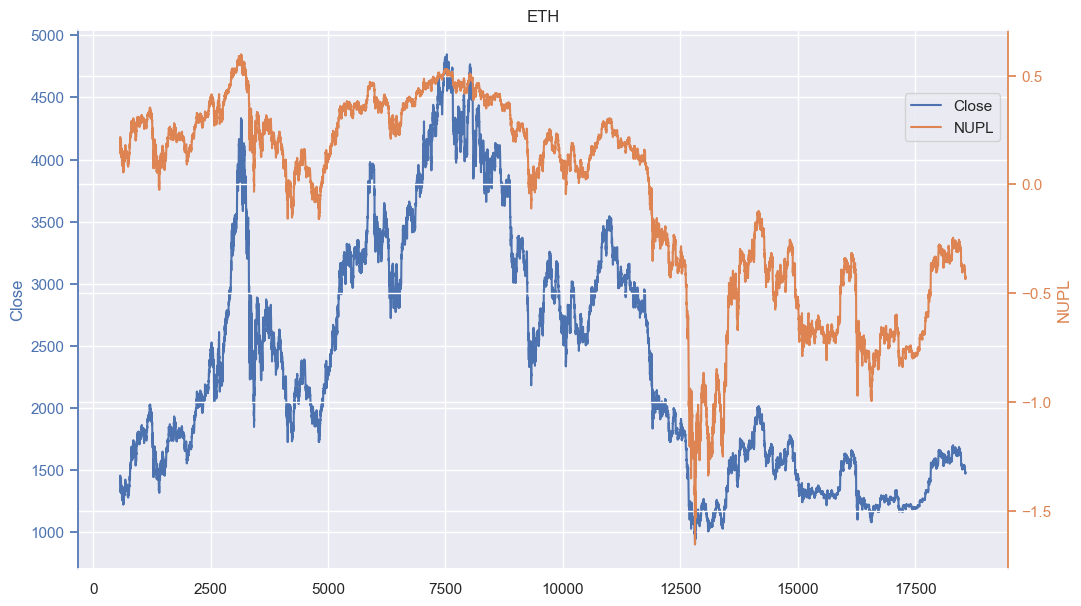

In [60]:
nb_point = 18000



fig, ax1 = plt.subplots()
fig.set_size_inches([12,7])
ax1.plot(df_eth[-nb_point:].Close)
ax1.set_ylabel('Close', color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title('ETH')

ax2 = ax1.twinx()
ax2.plot(df_eth[-nb_point:]["nupl"],'C1')
ax2.set_ylabel('NUPL', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(['Close','NUPL'], bbox_to_anchor=(0.9, 0.8))

plt.show()

Crypto Fear & Greed Index
- https://alternative.me/crypto/fear-and-greed-index/

In [95]:
# TODO : https://api.alternative.me/fng/?limit=370&format=csv
nb_days = int(np.ceil(df_eth.shape[0]/24))
response = requests.get(f"https://api.alternative.me/fng/?limit={nb_days}")

d_fear = json.loads(response.text)
nb_days = len(d_fear["data"])
df_fear = pd.DataFrame(
    [int(d_fear["data"][i_time]["timestamp"])*1000 
     for i_time in range(nb_days) ], columns=["Time"])
df_fear["fear_greed"] = [
    int(d_fear["data"][i_time]["value"]) 
    for i_time in range(nb_days)]
df_fear["fear_greed_class"] = [
    d_fear["data"][i_time]["value_classification"]
    for i_time in range(nb_days)]

df_eth = df_eth.merge(df_fear, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_eth["fear_greed"] = df_eth["fear_greed"].ffill()
df_eth["fear_greed_class"] = df_eth["fear_greed_class"].ffill()
df_eth.loc[df_eth["fear_greed"].isna(), "fear_greed"] = 50
df_eth.loc[df_eth["fear_greed_class"].isna(), "fear_greed_class"] = "Neutral"
df_eth

In [145]:
df_eth.head(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2327.873364,2320.213654,NaN,...,734.133333,734.133333,734.133333,734.133333,734.133333,734.133333,NaN,-0.000086,50.0,Neutral
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2327.873364,2320.213654,NaN,...,740.273102,740.273102,740.273102,740.273102,740.273102,740.273102,0.796866,0.010700,50.0,Neutral
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2327.873364,2320.213654,NaN,...,741.682885,741.682885,741.682885,741.682885,741.682885,741.682885,0.325738,0.003195,50.0,Neutral
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2327.873364,2320.213654,NaN,...,742.135753,742.135753,742.135753,742.135753,742.135753,742.135753,0.439488,0.003604,50.0,Neutral
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2327.873364,2320.213654,NaN,...,742.230872,742.230872,742.230872,742.230872,742.230872,742.230872,0.011168,0.000080,50.0,Neutral
5,1609477200000,742.34,743.23,739.50,740.65,14948.26447,2021-01-01 05:00:00,2327.873364,2320.213654,NaN,...,742.130615,742.130615,742.130615,742.130615,742.130615,742.130615,-0.307873,-0.001999,50.0,Neutral
6,1609480800000,740.72,743.25,737.04,739.97,17106.99495,2021-01-01 06:00:00,2327.873364,2320.213654,NaN,...,741.938223,741.938223,741.938223,741.938223,741.938223,741.938223,-0.439114,-0.002660,50.0,Neutral
7,1609484400000,739.87,740.51,734.40,737.38,21624.68945,2021-01-01 07:00:00,2327.873364,2320.213654,NaN,...,741.458849,741.458849,741.458849,741.458849,741.458849,741.458849,-0.914077,-0.005532,50.0,Neutral
8,1609488000000,737.37,738.48,725.10,730.07,52992.04892,2021-01-01 08:00:00,2327.873364,2320.213654,NaN,...,739.341687,739.341687,739.341687,739.341687,739.341687,739.341687,-1.644503,-0.012700,50.0,Neutral
9,1609491600000,730.07,734.77,728.77,733.68,22836.46973,2021-01-01 09:00:00,2327.873364,2320.213654,NaN,...,738.774446,738.774446,738.774446,738.774446,738.774446,738.774446,-0.893959,-0.006944,50.0,Neutral


In [133]:
df_eth.tail(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
18546,1676224800000,1540.97,1542.49,1538.04,1539.55,8212.027400,2023-02-12 18:00:00,1519.8950,1569.620,1526.510,...,1598.702696,1481.134564,2202.459804,2114.416241,1693.357001,2114.416241,-0.584348,-0.373399,NaN,NaN
18547,1676228400000,1539.56,1542.03,1535.89,1539.23,6511.003000,2023-02-12 19:00:00,1517.7250,1569.620,1526.510,...,1598.459310,1481.170385,2202.520249,2114.409983,1693.306285,2114.409983,-0.584672,-0.373680,NaN,NaN
18548,1676232000000,1539.23,1541.96,1536.67,1538.06,4905.318400,2023-02-12 20:00:00,1515.2250,1565.100,1531.110,...,1598.291892,1481.196398,2202.560096,2114.405268,1693.229439,2114.405268,-0.585862,-0.374722,NaN,NaN
18549,1676235600000,1538.06,1538.44,1508.33,1511.23,32827.497500,2023-02-12 21:00:00,1515.2250,1561.835,1528.175,...,1597.339429,1481.249901,2202.527036,2114.372640,1693.081743,2114.372640,-0.613107,-0.399107,NaN,NaN
18550,1676239200000,1511.22,1515.10,1493.08,1513.36,43552.645500,2023-02-12 22:00:00,1515.2250,1560.485,1520.550,...,1595.855797,1481.290550,2202.477439,2114.328473,1692.971827,2114.328473,-0.610902,-0.397109,NaN,NaN
18551,1676242800000,1513.35,1517.42,1509.10,1514.83,14837.428500,2023-02-12 23:00:00,1517.2600,1560.485,1520.550,...,1595.256984,1481.331103,2202.468239,2114.313592,1692.935500,2114.313592,-0.609398,-0.395743,NaN,NaN
18552,1676246400000,1514.82,1524.62,1506.02,1518.29,23889.890000,2023-02-13 00:00:00,1520.0700,1556.430,1520.550,...,1594.400780,1481.374410,2202.442899,2114.289733,1692.870962,2114.289733,-0.605862,-0.392547,48.0,Neutral
18553,1676250000000,1518.28,1520.00,1501.59,1507.03,26181.197400,2023-02-13 01:00:00,1523.7100,1536.225,1520.550,...,1593.544690,1481.417008,2202.413648,2114.263292,1692.815881,2114.263292,-0.617286,-0.402934,NaN,NaN
18554,1676253600000,1507.04,1512.71,1496.67,1512.14,25027.386400,2023-02-13 02:00:00,1523.8650,1534.035,1520.550,...,1592.694850,1481.511849,2202.382013,2114.237920,1692.776494,2114.237920,-0.612071,-0.398176,NaN,NaN
18555,1676257200000,1512.15,1518.00,1511.17,1516.81,8694.417000,2023-02-13 03:00:00,1524.0000,1522.505,1520.550,...,1592.339375,1481.550207,2202.375273,2114.229225,1692.745173,2114.229225,-0.607320,-0.393866,NaN,NaN


Other indicators : 
- LTH-MVRV ? equiv to Price / VWAP 6 months ago
- STH-MVRV ? equiv to Price / VWAP of the last 6 months
- Dave’s Logarithmic Growth Curve ?

Others tickers:

- US02Y
- ETHBTC
- SP500
- DXY

TODO ? 
- open interest 
- NASDAC


US02Y : 

In [210]:
FIRST_DATE

'2021-01-01 00:00:00'

In [213]:

datetime.strptime(FIRST_DATE, "%Y-%m-%d %H:%M:%S")

datetime.datetime(2021, 1, 1, 0, 0)

In [216]:
nb_days

774

In [219]:
2*365

730

In [215]:
FIRST_DATE

'2021-01-01 00:00:00'

In [220]:
# TODO : with yfinance ?
yf_eth = yf.Ticker("ETH-BTC")
y_first_date = datetime.strptime(FIRST_DATE, "%Y-%m-%d %H:%M:%S")
# 2021-08-13 06:00:00
#data = yf_eth.history(interval="1h", start="2021-08-13", end="2021-08-14")
data = yf_eth.history(interval="1h", period="2y")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-02-14 22:00:00+00:00,0.037406,0.037429,0.037154,0.037192,0,0.0,0.0
2021-02-14 23:00:00+00:00,0.037211,0.037241,0.037048,0.037048,5938,0.0,0.0
2021-02-15 00:00:00+00:00,0.037060,0.037145,0.037005,0.037031,0,0.0,0.0
2021-02-15 01:00:00+00:00,0.037038,0.037155,0.036445,0.036692,33909,0.0,0.0
2021-02-15 02:00:00+00:00,0.036676,0.036702,0.036297,0.036697,77292,0.0,0.0
...,...,...,...,...,...,...,...
2023-02-14 18:00:00+00:00,0.070038,0.070070,0.069919,0.070067,0,0.0,0.0
2023-02-14 19:00:00+00:00,0.070062,0.070217,0.069995,0.070190,5446,0.0,0.0
2023-02-14 20:00:00+00:00,0.070191,0.070263,0.070023,0.070030,1532,0.0,0.0


openbb  for index is not good about datetime and DXY no data

In [260]:
df_sp500 = openbb.economy.index(["^GSPC", '^NDX', "DX-Y.NYB"], interval="1h", start_date="2023-01-01")
df_sp500

,^GSPC,^NDX,DX-Y.NYB
Datetime,,,
2023-01-03 09:30:00,3823.179932,10861.505859,NaN
2023-01-03 10:30:00,3815.540039,10834.069336,NaN
2023-01-03 11:30:00,3804.169922,10794.881836,NaN
2023-01-03 12:30:00,3810.050049,10820.927734,NaN
2023-01-03 13:30:00,3804.979980,10824.702148,NaN
...,...,...,...
2023-02-14 11:30:00,4114.459961,12459.709961,NaN
2023-02-14 12:30:00,4134.399902,12542.611328,NaN
2023-02-14 13:30:00,4134.240234,12550.979492,NaN


In [258]:
openbb.economy.available_indices()

{'sp500': {'name': 'S&P 500 Index', 'ticker': '^GSPC'},
 'sp400': {'name': 'S&P 400 Mid Cap Index', 'ticker': '^SP400'},
 'sp600': {'name': 'S&P 600 Small Cap Index', 'ticker': '^SP600'},
 'sp500tr': {'name': 'S&P 500 TR Index', 'ticker': '^SP500TR'},
 'sp_xsp': {'name': 'S&P 500 Mini SPX Options Index', 'ticker': '^XSP'},
 'nyse_ny': {'name': 'NYSE US 100 Index', 'ticker': '^NY'},
 'dow_djus': {'name': 'Dow Jones US Index', 'ticker': '^DJUS'},
 'nyse': {'name': 'NYSE Composite Index', 'ticker': '^NYA'},
 'amex': {'name': 'NYSE-AMEX Composite Index', 'ticker': '^XAX'},
 'nasdaq': {'name': 'Nasdaq Composite Index', 'ticker': '^IXIC'},
 'nasdaq100': {'name': 'NASDAQ 100', 'ticker': '^NDX'},
 'nasdaq100_ew': {'name': 'NASDAQ 100 Equal Weighted Index',
  'ticker': '^NDXE'},
 'nasdaq50': {'name': 'NASDAQ Q50 Index', 'ticker': '^NXTQ'},
 'russell1000': {'name': 'Russell 1000 Index', 'ticker': '^RUI'},
 'russell2000': {'name': 'Russell 2000 Index', 'ticker': '^RUT'},
 'cboe_bxr': {'name': 'CB

In [268]:
openbb.economy.treasury(instruments=["nominal"], maturities=["2y"], frequency="daily", start_date="2023-01-01")

,Nominal_2-year
TIME_PERIOD,
2023-01-03,4.40
2023-01-04,4.36
2023-01-05,4.45
2023-01-06,4.24
2023-01-09,4.19
2023-01-10,4.24
2023-01-11,4.20
2023-01-12,4.12
2023-01-13,4.22


U.S. Treasury Yield 5 Years

In [277]:
df_fvx = yf.Ticker("^FVX").history(interval="1h", period="2y")
df_fvx

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-02-16 08:00:00-05:00,0.514,0.524,0.514,0.521,0,0.0,0.0
2021-02-16 09:00:00-05:00,0.521,0.527,0.516,0.527,0,0.0,0.0
2021-02-16 10:00:00-05:00,0.529,0.532,0.522,0.529,0,0.0,0.0
2021-02-16 11:00:00-05:00,0.529,0.553,0.529,0.551,0,0.0,0.0
2021-02-16 12:00:00-05:00,0.551,0.553,0.545,0.546,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-02-14 10:00:00-05:00,3.974,4.005,3.953,4.005,0,0.0,0.0
2023-02-14 11:00:00-05:00,4.005,4.038,3.992,4.021,0,0.0,0.0
2023-02-14 12:00:00-05:00,4.022,4.028,4.013,4.019,0,0.0,0.0


DXY

In [278]:
df_dxy = yf.Ticker("DX-Y.NYB").history(interval="1h", period="2y")
df_dxy

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-02-16 00:00:00-05:00,90.290001,90.334000,90.280998,90.305000,0,0.0,0.0
2021-02-16 01:00:00-05:00,90.306000,90.329002,90.292999,90.294998,0,0.0,0.0
2021-02-16 02:00:00-05:00,90.294998,90.375000,90.277000,90.362999,0,0.0,0.0
2021-02-16 03:00:00-05:00,90.362000,90.369003,90.205002,90.218002,0,0.0,0.0
2021-02-16 04:00:00-05:00,90.218002,90.269997,90.202003,90.220001,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-02-14 23:00:00-05:00,103.417000,103.452003,103.385002,103.412003,0,0.0,0.0
2023-02-15 00:00:00-05:00,103.410004,103.452003,103.375999,103.443001,0,0.0,0.0
2023-02-15 01:00:00-05:00,103.444000,103.543999,103.389999,103.529999,0,0.0,0.0


SPX

In [279]:
df_spx = yf.Ticker("^GSPC").history(interval="1h", period="2y")
df_spx

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0,0.0,0.0
2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448,0.0,0.0
2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147,0.0,0.0
2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202,0.0,0.0
2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714,0.0,0.0
...,...,...,...,...,...,...,...
2023-02-14 11:30:00-05:00,4108.560059,4118.629883,4095.010010,4114.459961,214614774,0.0,0.0
2023-02-14 12:30:00-05:00,4114.470215,4143.859863,4113.240234,4134.399902,214377283,0.0,0.0
2023-02-14 13:30:00-05:00,4134.470215,4138.520020,4122.470215,4134.240234,183621000,0.0,0.0


In [284]:

def req_yf_date(ticker):
    data = yf.Ticker(ticker).history(interval="1h", period="2y")
    data["date"] = pd.to_datetime(data.index, utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    exchange.parse8601(data["date"].values[0])
    data["Datetime"] = data["date"].apply(exchange.parse8601)
    return data

# S&P 500 = "^GSPC"
data = req_yf_date("^GSPC")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Datetime
Datetime,,,,,,,,,
2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0,0.0,0.0,2021-02-16T14:30:00Z,1613485800000
2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448,0.0,0.0,2021-02-16T15:30:00Z,1613489400000
2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147,0.0,0.0,2021-02-16T16:30:00Z,1613493000000
2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202,0.0,0.0,2021-02-16T17:30:00Z,1613496600000
2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714,0.0,0.0,2021-02-16T18:30:00Z,1613500200000
...,...,...,...,...,...,...,...,...,...
2023-02-14 11:30:00-05:00,4108.560059,4118.629883,4095.010010,4114.459961,214614774,0.0,0.0,2023-02-14T16:30:00Z,1676392200000
2023-02-14 12:30:00-05:00,4114.470215,4143.859863,4113.240234,4134.399902,214377283,0.0,0.0,2023-02-14T17:30:00Z,1676395800000
2023-02-14 13:30:00-05:00,4134.470215,4138.520020,4122.470215,4134.240234,183621000,0.0,0.0,2023-02-14T18:30:00Z,1676399400000


In [285]:
pd.Timestamp("2023-02-14 20:30:00").timestamp()

1676406600.0

In [283]:
yf.download(tickers = "SPY AAPL",  # list of tickers
            period = "1y",         # time period
            interval = "1h",       # trading interval
            ignore_tz = True,      # ignore timezone when aligning data from different exchanges?
            prepost = False)       # download pre/post market hours data?

[*********************100%***********************]  2 of 2 completed


Adj Close                   Close              \
                           AAPL         SPY        AAPL         SPY   
Datetime                                                              
2022-02-15 09:30:00  171.080002  444.970001  171.080002  444.970001   
2022-02-15 10:30:00  171.464996  444.980011  171.464996  444.980011   
2022-02-15 11:30:00  170.876007  444.339996  170.876007  444.339996   
2022-02-15 12:30:00  171.839996  445.380005  171.839996  445.380005   
2022-02-15 13:30:00  171.820007  445.339996  171.820007  445.339996   
...                         ...         ...         ...         ...   
2023-02-14 11:30:00  151.889893  410.479889  151.889893  410.479889   
2023-02-14 12:30:00  152.750000  412.505005  152.750000  412.505005   
2023-02-14 13:30:00  153.134995  412.529999  153.134995  412.529999   
2023-02-14 14:30:00  153.269608  413.100006  153.269608  413.100006   
2023-02-14 15:30:00  153.199997  412.640015  153.199997  412.640015   

                           High                     Low              \
                           AAPL         SPY        AAPL         SPY   
Datetime                                                              
2022-02-15 09:30:00  171.450607  445.779999  170.250000  443.450012   
2022-02-15 10:30:00  171.639999  445.989990  170.690002  444.609985   
2022-02-15 11:30:00  171.720001  445.910004  170.660904  443.850006   
2022-02-15 12:30:00  171.949997  445.489990  170.339996  443.179993   
2022-02-15 13:30:00  172.039993  445.600006  171.380005  444.459991   
...                         ...         ...         ...         ...   
2023-02-14 11:30:00  152.229996  410.980011  151.039993  408.510986   
2023-02-14 12:30:00  153.220001  413.549988  151.750000  410.338898   
2023-02-14 13:30:00  153.300003  412.989990  152.429993  411.230011   
2023-02-14 14:30:00  153.570007  413.649994  152.949905  412.399994   
2023-02-14 15:30:00  153.729996  413.700012  153.139999  412.640015   

                           Open                Volume            
                           AAPL         SPY      AAPL       SPY  
Datetime                                                         
2022-02-15 09:30:00  170.970001  443.730011  14651854  19052394  
2022-02-15 10:30:00  171.080002  444.970001   7501656  10139487  
2022-02-15 11:30:00  171.470001  444.989990   5604576   7268745  
2022-02-15 12:30:00  170.880005  444.359985   6255731   6774090  
2022-02-15 13:30:00  171.850006  445.380005   5257951   6957052  
...                         ...         ...       ...       ...  
2023-02-14 11:30:00  151.550003  409.859985   6071721   9061320  
2023-02-14 12:30:00  151.885300  410.489990   5258398   8498477  
2023-02-14 13:30:00  152.770004  412.510010   4533964   7072143  
2023-02-14 14:30:00  153.130005  412.529999   4288542   7706501  
2023-02-14 15:30:00  153.264999  413.100006   5069230  11250658  

[1753 rows x 12 columns]

In [281]:
data["Datetime"].nunique()

3520

In [207]:
'2018-01-01T00:00:00Z'
data["date"] = pd.to_datetime(data.index)
data["date"] = data["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
})
exchange.parse8601(data["date"].values[0])
data["date"].apply(exchange.parse8601)


Datetime
2021-08-13 00:00:00+00:00    1628812800000
2021-08-13 01:00:00+00:00    1628816400000
2021-08-13 02:00:00+00:00    1628820000000
2021-08-13 03:00:00+00:00    1628823600000
2021-08-13 04:00:00+00:00    1628827200000
2021-08-13 05:00:00+00:00    1628830800000
2021-08-13 06:00:00+00:00    1628834400000
2021-08-13 07:00:00+00:00    1628838000000
2021-08-13 08:00:00+00:00    1628841600000
2021-08-13 09:00:00+00:00    1628845200000
2021-08-13 10:00:00+00:00    1628848800000
2021-08-13 11:00:00+00:00    1628852400000
2021-08-13 12:00:00+00:00    1628856000000
2021-08-13 13:00:00+00:00    1628859600000
2021-08-13 14:00:00+00:00    1628863200000
2021-08-13 15:00:00+00:00    1628866800000
2021-08-13 16:00:00+00:00    1628870400000
2021-08-13 17:00:00+00:00    1628874000000
2021-08-13 18:00:00+00:00    1628877600000
2021-08-13 19:00:00+00:00    1628881200000
2021-08-13 20:00:00+00:00    1628884800000
2021-08-13 21:00:00+00:00    1628888400000
2021-08-13 22:00:00+00:00    1628892000000
20

In [205]:
data["date"] = pd.to_datetime(data.index)

Open-Interest

In [ ]:
# TODO Open Interest
# Binance with cctx : 30days limit
# see how to scrap data ?
response = exchange.fetchOpenInterestHistory(
    "BTC/USDT:USDT", 
    timeframe="1h",
    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),
    limit=10)

In [58]:
df_eth

,Time,Open,High,Low,Close,Volume,date,volume_adi,volume_obv,volume_cmf,...,ichi_kijun,ichi_tenkan,ichi_tenkan_day,ichi_cloud_a_day,ichi_cloud_b_day,ichi_kijun_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week
0,1640995200000,3676.22,3730.00,3676.22,3723.04,9023.3740,2022-01-01 00:00:00,6.687834e+03,9.023374e+03,0.741168,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
1,1640998800000,3723.04,3748.45,3714.10,3724.89,8997.7569,2022-01-01 01:00:00,3.342816e+03,1.802113e+04,0.185494,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
2,1641002400000,3724.88,3738.47,3722.23,3728.32,5028.4531,2022-01-01 02:00:00,2.085703e+03,2.304958e+04,0.090488,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
3,1641006000000,3728.41,3737.00,3721.84,3723.96,3543.1853,2022-01-01 03:00:00,-4.665126e+02,1.950640e+04,-0.017543,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
4,1641009600000,3723.96,3728.07,3707.24,3708.21,6117.2820,2022-01-01 04:00:00,-6.014062e+03,1.338912e+04,-0.183860,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1673377200000,1341.08,1344.04,1338.50,1339.48,22563.0593,2023-01-10 19:00:00,-1.949739e+06,-8.520347e+06,0.139166,...,1329.995,1333.555,1268.955,1249.612500,1376.765000,1247.71,1948.707500,2391.145000,1518.16,1213.125
8996,1673380800000,1339.48,1347.69,1335.08,1341.98,22371.3361,2023-01-10 20:00:00,-1.947628e+06,-8.497976e+06,0.105158,...,1331.385,1335.380,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125
8997,1673384400000,1341.97,1343.21,1338.76,1339.01,14307.3162,2023-01-10 21:00:00,-1.960328e+06,-8.512283e+06,0.110837,...,1331.385,1335.380,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125
8998,1673388000000,1339.00,1339.45,1334.45,1334.46,11972.0830,2023-01-10 22:00:00,-1.972252e+06,-8.524255e+06,0.099342,...,1331.385,1336.135,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125


In [80]:
df_eth.iloc[-1]["date"]

Timestamp('2023-01-10 23:00:00')

In [83]:
int(df_eth.iloc[-1]["date"].timestamp()*1000)

1673391600000

In [74]:
type(df_eth.iloc[-1]["date"])

pandas._libs.tslibs.timestamps.Timestamp

In [72]:
df_eth.iloc[-1]["date"].timestamp()

1673391600.0

In [68]:
type(int(df_eth.iloc[-1]["Time"]))

int

In [76]:
pd.Timestamp("2023-01-20 23:00:00").timestamp()

1674255600.0

Economy calendar

In [237]:


if os.path.isfile(path_save_df_eco):
    df_eco = pd.read_csv(path_save_df_eco)
else:
    df_eco = openbb.economy.events(start_date="2021-01-01", countries = ['United States'])

In [241]:
df_eco.to_csv(path_save_df_eco,index=False)

In [242]:
df_eco

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
0,All Day,United States,United States - New Year's Day,-,-,-,2021-01-01
1,09:45,United States,Manufacturing PMI,57.1,-,56.5,2021-01-04
2,10:00,United States,Chicago Fed President Evans Speaks,-,-,-,2021-01-04
3,10:00,United States,Construction Spending,0.9%,1.0%,1.6%,2021-01-04
4,10:00,United States,FOMC Member Bostic Speaks,-,-,-,2021-01-04
...,...,...,...,...,...,...,...
9716,13:00,United States,20-Year Bond Auction,-,-,3.678%,2023-02-15
9717,16:00,United States,"US Foreign Buying, T-bonds",-,-,54.20B,2023-02-15
9718,16:00,United States,Overall Net Capital Flow,-,-,213.10B,2023-02-15
9719,16:00,United States,TIC Net Long-Term Transactions,-,-,171.5B,2023-02-15


In [236]:
df_eco["Country"].unique()

array(['United States'], dtype=object)

Other temporal infos :   
  - Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
  -  day/week/month/year/halving cycle (maybe to short if only 2 year) ?

Active addresses

,date,act_add
0,2021-01-01,996185
1,2021-01-02,1138629
2,2021-01-03,1188455
3,2021-01-04,1274837
4,2021-01-05,1234388
...,...,...
770,2023-02-10,914530
771,2023-02-11,881403
772,2023-02-12,874172
773,2023-02-13,968062


In [322]:
df_active_eth = openbb.crypto.dd.active(symbol = 'ETH', interval = '24h', start_date = '2021-01-01')
df_active_eth = df_active_eth.reset_index()
df_active_eth.rename(columns = {'v': 'Active Addresses', 't': 'Date'}, inplace = True)
df_active_eth.set_index(keys = ['Date'], inplace = True)
df_active_eth

,Active Addresses
Date,
2021-01-01,445278
2021-01-02,422461
2021-01-03,492481
2021-01-04,513954
2021-01-05,507048
...,...
2023-02-10,419620
2023-02-11,380981
2023-02-12,378777


On-Chain data : 
  - Market Supply BTC ETH : OK 
  - % Staked ETH : NOK
  - nb of address with  BTC & ETH : OK

Circulating Supply

In [400]:
timezone.utc

datetime.timezone.utc

In [395]:
timestamp = exchange.seconds()
date_time = datetime.fromtimestamp(timestamp)
date_time.strftime("%Y-%m-%d %H:%M:%S")

'2023-02-15 17:03:38'

In [396]:
date_time

datetime.datetime(2023, 2, 15, 17, 3, 38)

1676476745.6049

In [403]:
now = datetime.now()
print(now)
now.strftime("%Y/%m/%d %H:%M:%S")

2023-02-15 17:16:35.886534


'2023/02/15 17:16:35'

'2023/02/15 17:14:30'

In [402]:
now_utc = datetime.now(timezone.utc)
print(now_utc)
now_utc.strftime("%Y/%m/%d %H:%M:%S")

2023-02-15 16:16:03.096643+00:00


'2023/02/15 16:16:03'

In [423]:

print(FIRST_DATE)
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2021-01-01 00:00:00


'2021-01-01'

In [424]:
print("2021-01-01 23:59:00")
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2021-01-01 23:59:00


'2021-01-01'

In [384]:
exchange.iso8601(exchange.milliseconds())

'2023-02-15T15:54:53.020Z'

In [431]:
# Time : timestamp unix
# date : 2000-01-01 00:00:00
def req_active_addresses(symbol, since=FIRST_DATE):
    since = datetime.fromtimestamp(
        int(pd.Timestamp(since).timestamp())).strftime("%Y-%m-%d")
    df_active = openbb.crypto.dd.active(
        symbol = symbol,
        interval = '24h',
        start_date = since,
    )
    df_active = df_active.reset_index()
    df_active.rename(columns = {
        'v': f'act_addr_{symbol}',
        't': 'date'
        }, 
        inplace = True)
    return df_active

def req_supply(symbol, since=FIRST_DATE):
    res = requests.get('https://api.glassnode.com/v1/metrics/supply/current',
        params={
            'a': symbol, 
            'api_key': API_GLASSNODE_KEY, 
            "i": "24h",
            "s": int(pd.Timestamp(since).timestamp())
        }
    )
    # convert to pandas dataframe
    df_supply = pd.read_json(res.text, convert_dates=['t'])
    df_supply.rename(
        columns = {'v': f'supply_{symbol}', 't': 'date'}, inplace = True)
    
    # get active adresses
    print("Get active adresses...")
    df_active = req_active_addresses(symbol, since=since)    

    df_supply = df_supply.merge(
        df_active, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    # get market dominance
    print("Get market dominance...")
    df_mcapdom = openbb.crypto.dd.mcapdom(symbol=symbol, start_date=since)
    df_mcapdom = df_mcapdom.reset_index()
    df_mcapdom.rename(
        columns = {
            'marketcap_dominance': f'market_dom_{symbol}',
            'timestamp': 'date'
        }, 
        inplace = True,
    )
    # Correct last values : patch openbb data...
    if df_mcapdom[f'market_dom_{symbol}'].values[-2] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-3]:
        print("Correcting dominance value index -2:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-3,f'market_dom_{symbol}']
        )
    if df_mcapdom[f'market_dom_{symbol}'].values[-1] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-2]:
        print("Correcting dominance value index -1:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-1,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}']
        )

    df_supply = df_supply.merge(
        df_mcapdom, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    return df_supply

def get_onchain(symbol, since=FIRST_DATE):
    path_df = os.path.join(PATH_DATA, f"df_supply_{symbol}.csv")
    
    if os.path.isfile(path_df):
        print(f"Read from {path_df}")
        df_supply = pd.read_csv(path_df)
        df_supply["date"] = df_supply["date"].astype(np.datetime64)
        
    else:
        df_supply = req_supply(symbol, since=since)
        df_supply.to_csv(path_df, index=False)
        print(f"Written in {path_df}")
    return df_supply


In [432]:
df_supply_btc = get_onchain("BTC")
df_supply_btc

Get active adresses...
Index(['date', 'BTC_supply', 'act_addr_BTC'], dtype='object')
Get market dominance...
Correcting dominance value index -2:  
Correcting dominance value index -1:  
Index(['date', 'BTC_supply', 'act_addr_BTC', 'market_dom_BTC'], dtype='object')
Written in data/df_supply_BTC.csv


,date,BTC_supply,act_addr_BTC,market_dom_BTC
0,2021-01-01,18587887.50,996185,70.586620
1,2021-01-02,18588831.25,1138629,71.699338
2,2021-01-03,18589818.75,1188455,71.249134
3,2021-01-04,18590900.00,1274837,68.440489
4,2021-01-05,18591881.25,1234388,68.486749
...,...,...,...,...
770,2023-02-10,19287206.25,914530,40.695688
771,2023-02-11,19288131.25,881403,40.623618
772,2023-02-12,19289143.75,874172,40.547707
773,2023-02-13,19290118.75,968062,40.665689


In [364]:
df_active_btc = openbb.crypto.dd.active(symbol = 'BTC', interval = '24h', start_date = '2021-01-01')
df_active_btc = df_active_btc.reset_index()
df_active_btc.rename(columns = {'v': 'act_add', 't': 'date'}, inplace = True)
#df_active_btc.set_index(keys = ['Date'], inplace = True)
df_active_btc

,date,act_add
0,2021-01-01,996185
1,2021-01-02,1138629
2,2021-01-03,1188455
3,2021-01-04,1274837
4,2021-01-05,1234388
...,...,...
770,2023-02-10,914530
771,2023-02-11,881403
772,2023-02-12,874172
773,2023-02-13,968062


In [379]:
df_supply_btc = get_onchain("BTC")
df_supply_btc

Read from data/df_supply_BTC.csv


,date,BTC_supply
0,2021-01-01,18587887.50
1,2021-01-02,18588831.25
2,2021-01-03,18589818.75
3,2021-01-04,18590900.00
4,2021-01-05,18591881.25
...,...,...
770,2023-02-10,19287206.25
771,2023-02-11,19288131.25
772,2023-02-12,19289143.75
773,2023-02-13,19290118.75


In [380]:
df_supply_btc["date"]

0     2021-01-01
1     2021-01-02
2     2021-01-03
3     2021-01-04
4     2021-01-05
         ...    
770   2023-02-10
771   2023-02-11
772   2023-02-12
773   2023-02-13
774   2023-02-14
Name: date, Length: 775, dtype: datetime64[ns]

In [371]:
df_active_btc["date"]

0     2021-01-01
1     2021-01-02
2     2021-01-03
3     2021-01-04
4     2021-01-05
         ...    
770   2023-02-10
771   2023-02-11
772   2023-02-12
773   2023-02-13
774   2023-02-14
Name: date, Length: 775, dtype: datetime64[ns]

,date,BTC_supply,act_add
0,2021-01-01,18587887.50,996185
1,2021-01-02,18588831.25,1138629
2,2021-01-03,18589818.75,1188455
3,2021-01-04,18590900.00,1274837
4,2021-01-05,18591881.25,1234388
...,...,...,...
770,2023-02-10,19287206.25,914530
771,2023-02-11,19288131.25,881403
772,2023-02-12,19289143.75,874172
773,2023-02-13,19290118.75,968062


In [360]:
df_supply_eth = get_supply("ETH")
df_supply_eth

Read from data/df_supply_ETH.csv


,date,ETH_supply
0,2021-01-01,1.140938e+08
1,2021-01-02,1.141080e+08
2,2021-01-03,1.141221e+08
3,2021-01-04,1.141361e+08
4,2021-01-05,1.141503e+08
...,...,...
770,2023-02-10,1.205176e+08
771,2023-02-11,1.205169e+08
772,2023-02-12,1.205163e+08
773,2023-02-13,1.205143e+08


In [344]:
int(pd.Timestamp("2021-01-01").timestamp()*1000)

1609459200000

In [ ]:
# not working since 2021-01-01 : messari data with openbb:
openbb.crypto.dd.tk(symbol="BTC", coingecko_id="bitcoin")

Market dominance

In [415]:
#openbb.crypto.dd.mcapdom(symbol: str, interval: str = "1d", start_date: Optional[str] = None, end_date: Optional[str] = None)
df_mcapdom_btc = openbb.crypto.dd.mcapdom(symbol="BTC", start_date="2021-01-01")
df_mcapdom_btc = df_mcapdom_btc.reset_index()
df_mcapdom_btc.rename(columns = {'marketcap_dominance': 'market_dom', 'timestamp': 'date'}, inplace = True)

if df_mcapdom_btc["market_dom"].values[-2] < 0.1 * df_mcapdom_btc["market_dom"].values[-3]:
    print("Correcting dominance value index -2:  ")
    df_mcapdom_btc.loc[df_mcapdom_btc.shape[0]-2,"market_dom"] =  (
        df_mcapdom_btc.loc[df_mcapdom_btc.shape[0]-3,"market_dom"]
    )
if df_mcapdom_btc["market_dom"].values[-1] < 0.1 * df_mcapdom_btc["market_dom"].values[-2]:
    print("Correcting dominance value index -1:  ")
    df_mcapdom_btc.loc[df_mcapdom_btc.shape[0]-1,"market_dom"] =  (
        df_mcapdom_btc.loc[df_mcapdom_btc.shape[0]-2,"market_dom"]
    )   
df_mcapdom_btc

Correcting dominance value index -2:  
Correcting dominance value index -1:  


,date,market_dom
0,2021-01-01,70.586620
1,2021-01-02,71.699338
2,2021-01-03,71.249134
3,2021-01-04,68.440489
4,2021-01-05,68.486749
...,...,...
771,2023-02-11,40.623618
772,2023-02-12,40.547707
773,2023-02-13,40.665689
774,2023-02-14,40.665689


In [411]:
df_mcapdom_btc.loc[df_mcapdom_btc.shape[0]-2,"market_dom"]

1.150323758974722e-29

In [320]:
df_mcapdom_eth = openbb.crypto.dd.mcapdom(symbol="ETH", start_date="2021-01-01")
df_mcapdom_eth

,marketcap_dominance
timestamp,
2021-01-01,1.080423e+01
2021-01-02,1.054693e+01
2021-01-03,1.168572e+01
2021-01-04,1.350779e+01
2021-01-05,1.365765e+01
...,...
2023-02-11,1.803269e+01
2023-02-12,1.810482e+01
2023-02-13,1.794176e+01


Temporal info

In [ ]:
# TODO Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
# TODO add sin/cos of day/week/month/year/halving cycle (maybe to short if only 2 year) ?
# TODO 

In [79]:
int(pd.Timestamp("2023-01-20 23:00:00").timestamp())

1674255600

In [339]:
pd.Timestamp("2021-01-01").timestamp()

1609459200.0

In [35]:
df_test = ta.add_all_ta_features(df_eth, "Open", "High", "Low", "Close", "Volume", fillna=True)
print(df_test.shape)
df_test

8800   2023-01-02 16:00:00
8801   2023-01-02 17:00:00
8802   2023-01-02 18:00:00
8803   2023-01-02 19:00:00
8804   2023-01-02 20:00:00
               ...        
8995   2023-01-10 19:00:00
8996   2023-01-10 20:00:00
8997   2023-01-10 21:00:00
8998   2023-01-10 22:00:00
8999   2023-01-10 23:00:00
Name: date, Length: 200, dtype: datetime64[ns]

In [41]:
df_test.columns.to_list()

['Time',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'date',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 '

In [44]:
df_test["momentum_rsi"]

0       100.000000
1       100.000000
2       100.000000
3        52.298392
4        18.313576
           ...    
8995     63.624256
8996     65.489364
8997     61.457829
8998     55.791435
8999     56.882902
Name: momentum_rsi, Length: 9000, dtype: float64